RMSE: 18622.045


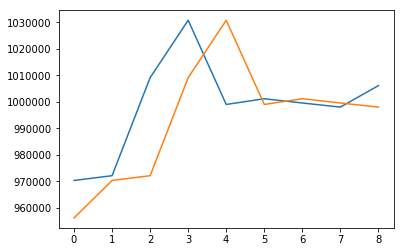

In [2]:
#baseline model
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# load dataset
dataframe = pandas.read_csv('Tot_dep_2017_Aug_dda.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32') 
# split data into train and test
#X = dataset.values
train, test = dataset[0:-9], dataset[-9:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

In [8]:
print(test)

[[  929498.]
 [  938051.]
 [  956401.]
 [  970524.]
 [  972325.]
 [ 1009297.]
 [ 1030944.]
 [  999188.]
 [ 1001338.]
 [  999739.]
 [  998187.]
 [ 1006291.]]


C:\Users\dbing\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Month=1, Predicted=973749.312500, Expected=970371.000000
Month=2, Predicted=977188.187500, Expected=972170.000000
Month=3, Predicted=1003797.875000, Expected=1009137.000000
Month=4, Predicted=1035275.687500, Expected=1030781.000000
Month=5, Predicted=994462.687500, Expected=999030.000000
Month=6, Predicted=999454.562500, Expected=1001178.000000
Month=7, Predicted=1001987.625000, Expected=999582.000000
Month=8, Predicted=1001209.562500, Expected=998032.000000
Month=9, Predicted=1004562.500000, Expected=1006136.000000
Test RMSE: 3763.776


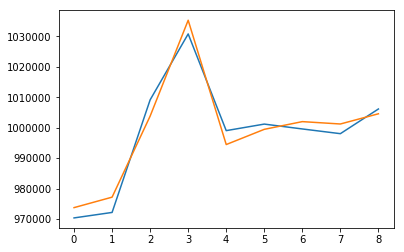

In [14]:
#LSTM model 20 neuron 5000 epoch
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
dataframe = pandas.read_csv('Tot_dep_2017_Aug_mult.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32') 

# transform data to be stationary
# transform data to be stationary
raw_values = dataset
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-9], supervised_values[-9:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 5000, 20)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-9:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-9:])
pyplot.plot(predictions)
pyplot.show()

C:\Users\dbing\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Month=1, Predicted=972316.250000, Expected=970371.000000
Month=2, Predicted=971267.187500, Expected=972170.000000
Month=3, Predicted=1008872.937500, Expected=1009137.000000
Month=4, Predicted=1036332.875000, Expected=1030781.000000
Month=5, Predicted=998983.375000, Expected=999030.000000
Month=6, Predicted=1000184.312500, Expected=1001178.000000
Month=7, Predicted=999275.625000, Expected=999582.000000
Month=8, Predicted=1000927.312500, Expected=998032.000000
Month=9, Predicted=1004600.562500, Expected=1006136.000000
Test RMSE: 2292.887


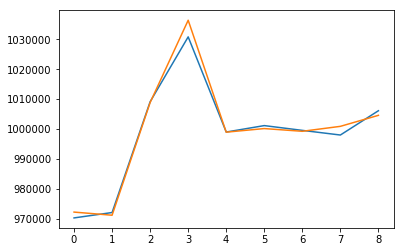

In [25]:
#LSTM model 21 neuron 5000 epoch with drop out

from keras.layers import LSTM, Dropout

#LSTM model
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dropout(0.2))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
dataframe = pandas.read_csv('Tot_dep_2017_Aug_mult.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32') 

# transform data to be stationary
# transform data to be stationary
raw_values = dataset
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-9], supervised_values[-9:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 5000, 21)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-9:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-9:])
pyplot.plot(predictions)
pyplot.show()

C:\Users\dbing\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


1) Test RMSE: 3880.096
2) Test RMSE: 3289.634
3) Test RMSE: 3976.612
4) Test RMSE: 4838.236
5) Test RMSE: 4841.496
6) Test RMSE: 5968.086
7) Test RMSE: 16188.502
8) Test RMSE: 2696.102
9) Test RMSE: 6136.977
10) Test RMSE: 14314.044
               rmse
count     10.000000
mean    6612.978609
std     4699.089761
min     2696.101816
25%     3904.225324
50%     4839.865943
75%     6094.754689
max    16188.502093


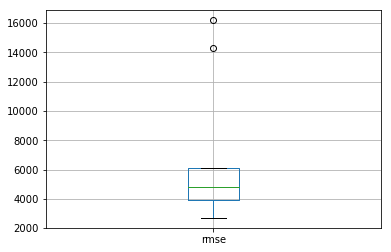

In [20]:
#LSTM model 4 neruons 10 trys for robust testing
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
dataframe = pandas.read_csv('Tot_dep_2017_Aug_dda.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32') 

# transform data to be stationary
# transform data to be stationary
raw_values = dataset
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-9], supervised_values[-9:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 10
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 5000, 20)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-9:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

C:\Users\dbing\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


1) Test RMSE: 10296.624
2) Test RMSE: 8576.661
3) Test RMSE: 7905.492
4) Test RMSE: 5273.712
5) Test RMSE: 4256.290
6) Test RMSE: 3172.786
7) Test RMSE: 9080.935
8) Test RMSE: 2945.589
9) Test RMSE: 4851.893
10) Test RMSE: 4650.808
               rmse
count     10.000000
mean    6101.078998
std     2627.844568
min     2945.588905
25%     4354.919368
50%     5062.802615
75%     8408.868894
max    10296.624301


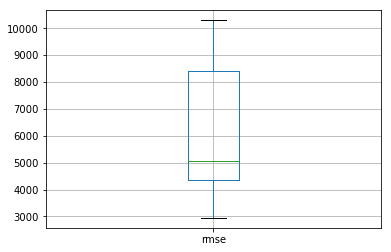

In [4]:
#LSTM model 6 neruons 30 trys for robust testing
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
from keras.layers import LSTM, Dropout

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dropout(0.2))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
dataframe = pandas.read_csv('Tot_dep_2017_Aug_dda.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32') 

# transform data to be stationary
# transform data to be stationary
raw_values = dataset
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-9], supervised_values[-9:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 10
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 5000, 21)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-9:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

C:\Users\dbing\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


1) Test RMSE: 3883.871
2) Test RMSE: 4766.449
3) Test RMSE: 6394.472
4) Test RMSE: 6532.490
5) Test RMSE: 7428.140
6) Test RMSE: 14806.334
7) Test RMSE: 10298.949
8) Test RMSE: 9413.658
9) Test RMSE: 14425.997
10) Test RMSE: 4154.218
11) Test RMSE: 4090.181
12) Test RMSE: 4551.396
13) Test RMSE: 11132.854
14) Test RMSE: 6585.431
15) Test RMSE: 7458.179
16) Test RMSE: 3408.602
17) Test RMSE: 6913.900
18) Test RMSE: 4848.446
19) Test RMSE: 9681.108
20) Test RMSE: 5296.309
21) Test RMSE: 6176.726
22) Test RMSE: 4032.826
23) Test RMSE: 10676.028
24) Test RMSE: 6039.367
25) Test RMSE: 12347.256
26) Test RMSE: 20088.298
27) Test RMSE: 16855.668
28) Test RMSE: 25824.029
29) Test RMSE: 6170.695
30) Test RMSE: 5402.272
               rmse
count     30.000000
mean    8656.138313
std     5292.021347
min     3408.602500
25%     4960.411678
50%     6558.960842
75%    10581.758160
max    25824.028501


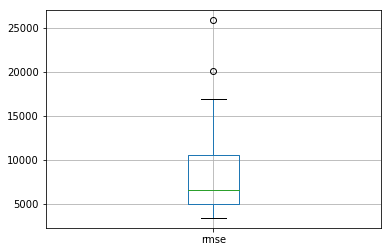

In [17]:
#LSTM model 10 neruons 30 trys for robust testing
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
dataframe = pandas.read_csv('Tot_dep_2017_Aug_dda.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32') 

# transform data to be stationary
# transform data to be stationary
raw_values = dataset
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-9], supervised_values[-9:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 5000, 10)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-9:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()